## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [35]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5.0,0.0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train['label'].nunique()

10

In [19]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103.0,87.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0,0,0,0,14,53,99,...,0.0,0.0,0.0,0.0,63.0,53.0,31.0,0.0,0.0,0.0
3,2,0,0,0,0,0,0,0,0,0,...,137.0,126.0,140.0,0.0,133.0,224.0,222.0,56.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

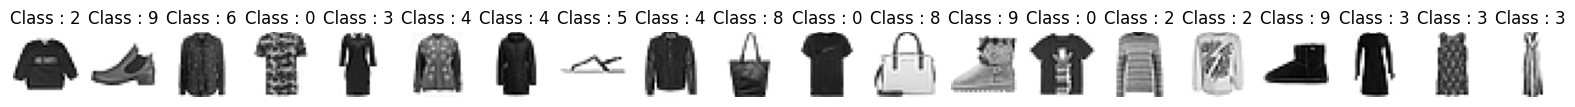

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [37]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

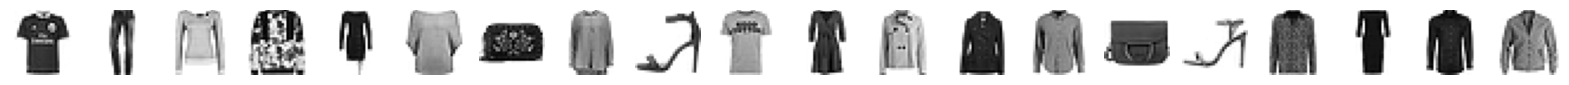

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [39]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [40]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [41]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [42]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [43]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [28]:
from torch import optim

첫 번째 방법 시도

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyNet(nn.Module):
    def __init__(self) -> None:
        super(MyNet, self).__init__()
        # 예제를 위해 임의의 레이어 크기를 설정함. 실제 데이터에 맞게 조정 필요.
        self.layer1 = nn.Linear(784, 128) # 예: 입력 벡터 크기가 784, 첫 번째 은닉층 뉴런 수가 128
        self.layer2 = nn.Linear(128, 64)  # 두 번째 은닉층 뉴런 수가 64
        self.layer3 = nn.Linear(64, 10)   # 출력층 뉴런 수가 10 (예: 10개 클래스 분류)

        # 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x) # 출력층은 보통 활성화 함수 적용 전
        return x

# DEVICE 설정: "cuda" 또는 "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyNet().to(DEVICE)

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

2번째 방법 시도

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyNet(nn.Module):
    def __init__(self) -> None:
        super(MyNet, self).__init__()
        # Layer 구성
        self.layer1 = nn.Linear(784, 50)
        self.batch_norm1 = nn.BatchNorm1d(50)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(50, 10)

        # 가중치 초기화 메서드 호출
        self._initialize_weights()

    def forward(self, x):
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

    def _initialize_weights(self):
        # 가중치 초기화 방법 예제
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# DEVICE 설정: "cuda" 또는 "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyNet().to(DEVICE)

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.9362, 	Train Accuracy: 69.60 %, 	Val Loss: 0.5170, 	Val Accuracy: 82.24 % 

[EPOCH: 2], 	Train Loss: 0.5619, 	Train Accuracy: 80.34 %, 	Val Loss: 0.4538, 	Val Accuracy: 84.28 % 

[EPOCH: 3], 	Train Loss: 0.5006, 	Train Accuracy: 82.51 %, 	Val Loss: 0.4151, 	Val Accuracy: 85.22 % 

[EPOCH: 4], 	Train Loss: 0.4627, 	Train Accuracy: 83.72 %, 	Val Loss: 0.3991, 	Val Accuracy: 85.95 % 

[EPOCH: 5], 	Train Loss: 0.4347, 	Train Accuracy: 84.69 %, 	Val Loss: 0.3878, 	Val Accuracy: 86.11 % 

[EPOCH: 6], 	Train Loss: 0.4163, 	Train Accuracy: 85.10 %, 	Val Loss: 0.3773, 	Val Accuracy: 86.79 % 

[EPOCH: 7], 	Train Loss: 0.4027, 	Train Accuracy: 85.59 %, 	Val Loss: 0.3719, 	Val Accuracy: 86.63 % 

[EPOCH: 8], 	Train Loss: 0.3912, 	Train Accuracy: 86.22 %, 	Val Loss: 0.3606, 	Val Accuracy: 87.03 % 

[EPOCH: 9], 	Train Loss: 0.3767, 	Train Accuracy: 86.59 %, 	Val Loss: 0.3565, 	Val Accuracy: 87.18 % 

[EPOCH: 10], 	Train Loss: 0.3707, 	Train Accuracy: 86.80 %, 	Val Loss: 0.

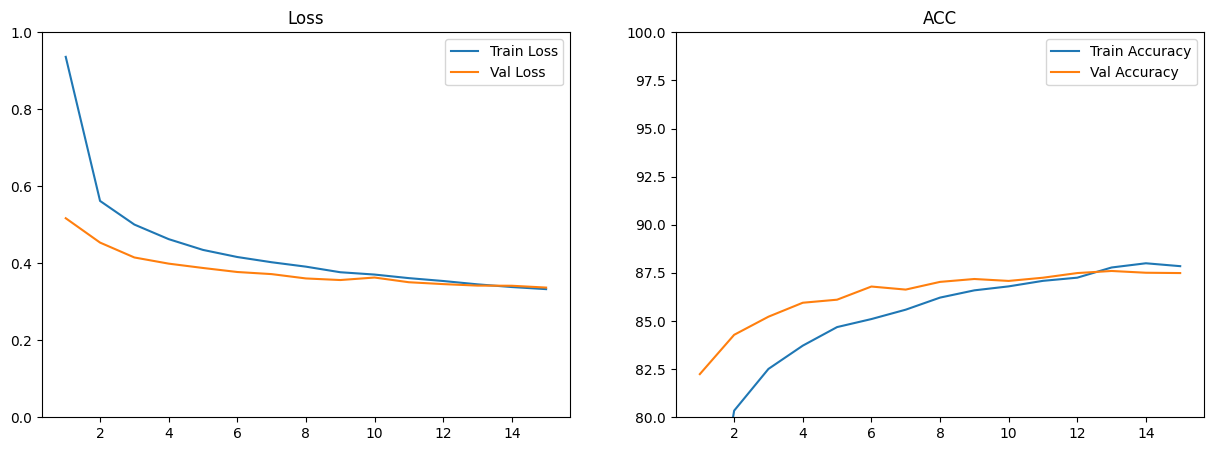

In [47]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
배치 정규화, 드롭아웃 적용, 그리고 적절한 활성화 함수의 사용이 모델의 일반화 능력과 성능 향상에 기여함을 보여준다.
모델은 안정적인 학습 곡선을 유지하며, 과적합 없이 일관된 성능 개선을 보였다.
nn.BatchNorm1d는 첫 번째 은닉층의 출력에 배치 정규화를 적용하며,
nn.Dropout은 과적합을 방지하기 위해 훈련 중에 뉴런의 일부를 무작위로 0으로 설정한다.
가중치 초기화는 kaiming_normal_ 메서드를 사용하여 진행하며, 이는 ReLU 활성화 함수와 잘 작동하도록 하기 위함이다.

'''